# All sagemaker code has been commented , uncommect to use it on sagemaker

In [23]:
#import boto3
#import sagemaker
#from sagemaker import get_execution_role
import sys
import IPython
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import time
from time import sleep,gmtime,strftime
import os
import warnings
warnings.filterwarnings("ignore")


In [24]:
data=pd.read_csv("rawdata/spam.csv",encoding="ISO-8859-1")
data.shape

(5572, 5)

In [25]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Inference - our data has 5 columns and 5572 rows , all of type object  

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2.Data Cleaning </h2>
</div>

In [26]:
#lets rename the column names and give them more understanding name
data.rename(columns={"v1":'label',"v2":"text"},inplace=True)
data.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [27]:
#lets check the missing value counts
data.isna().sum()

label            0
text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

### Data Imputation Inference - this looks unnamed2,3,4 column has more than 99% data missing , lets drop this features 

In [28]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [29]:
#feature encoding - converting target categorical column into numerical

data['label']=data['label'].map({"ham":0,"spam":1})
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [30]:
#lets check & remove the duplicates
data.duplicated().sum()
data.drop_duplicates(keep='first')

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Inference  - after cleaning the missing values and duplicate values , we have finally 5169 rows and 2 columns , here label column is our target variable and text column has sms text

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3.EDA </h2>
</div>

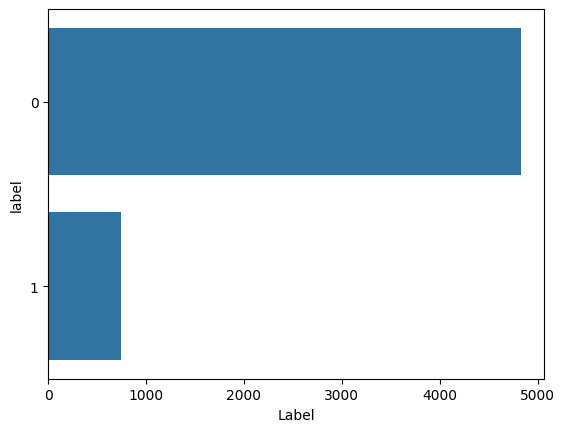

In [31]:
#lets check the counts of label variable 
#plt.figure(figsize=(12,6))
data_eda=data.copy()
sns.countplot(data=data_eda,y='label')
plt.xlabel("Label")

plt.show()
import warnings
warnings.filterwarnings("ignore")

### Inference - label class is highly imbalanced 

##### understand the sms text to check how many words, sentence and characters are present in each text 

In [32]:

#!pip install nltk   #--install the packages for first time
import nltk
nltk.download('punkt')

#import nltk: This line imports the NLTK library into your Python environment. 
# NLTK provides various tools and resources for working with human language data.

# nltk.download('punkt'): 
# The 'punkt' tokenizer is used for tokenization, which means breaking text into individual words or sentences (tokenizing them) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karlj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
data_eda['num_characters']=data_eda['text'].apply(len) #getting the length of each sentence usinh chracters len
data_eda['num_words']=data_eda['text'].apply(lambda x : len(nltk.word_tokenize(x))) #getting the words count in each sentence
data_eda['num_sentences']=data_eda['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
data_eda.describe()


,label,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,80.118808,18.699390,1.996411
std,0.340751,59.690841,13.741932,1.520159
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,61.000000,15.000000,1.500000
75%,0.000000,121.000000,27.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [34]:
#spam and ham messages count as per num_chracters,words, sentences
data_eda.groupby('label')[['num_characters','num_words','num_sentences']].describe().T

label                           0           1
num_characters count  4825.000000  747.000000
               mean     71.023627  138.866131
               std      58.016023   29.183082
               min       2.000000   13.000000
               25%      33.000000  132.500000
               50%      52.000000  149.000000
               75%      92.000000  157.000000
               max     910.000000  224.000000
num_words      count  4825.000000  747.000000
               mean     17.276269   27.891566
               std      13.988585    6.867007
               min       1.000000    2.000000
               25%       8.000000   25.000000
               50%      13.000000   29.000000
               75%      22.000000   32.000000
               max     220.000000   46.000000
num_sentences  count  4825.000000  747.000000
               mean      1.837720    3.021419
               std       1.454388    1.537580
               min       1.000000    1.000000
               25%       1.000000    2.000000
               50%       1.000000    3.000000
               75%       2.000000    4.000000
               max      38.000000    9.000000

<Axes: xlabel='num_sentences', ylabel='Count'>

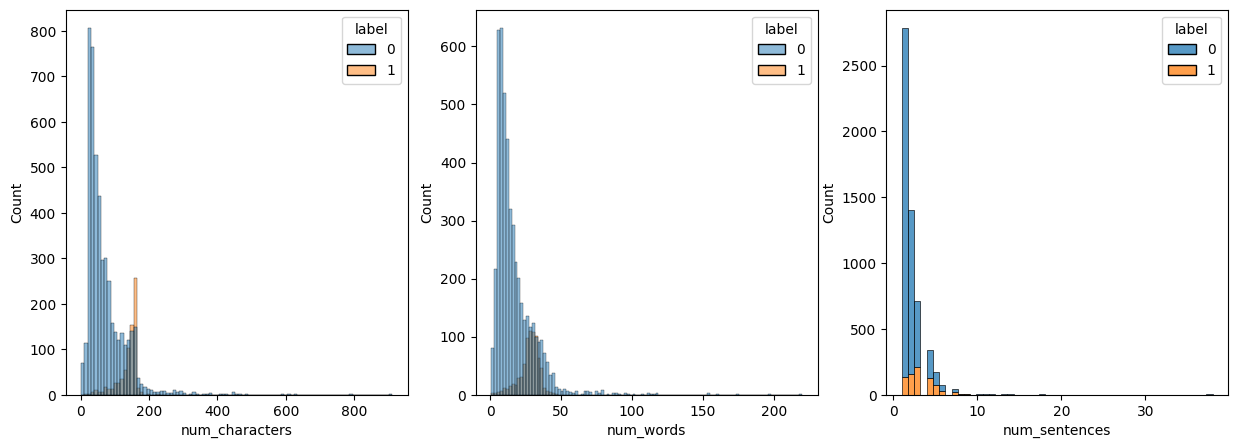

In [35]:
#visualize the histplot 
fix,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.histplot(data=data_eda,x='num_characters',hue='label',ax=ax[0])
sns.histplot(data=data_eda,x='num_words',hue='label',ax=ax[1])
sns.histplot(data=data_eda,x='num_sentences',hue='label',ax=ax[2],bins=50,multiple='stack')

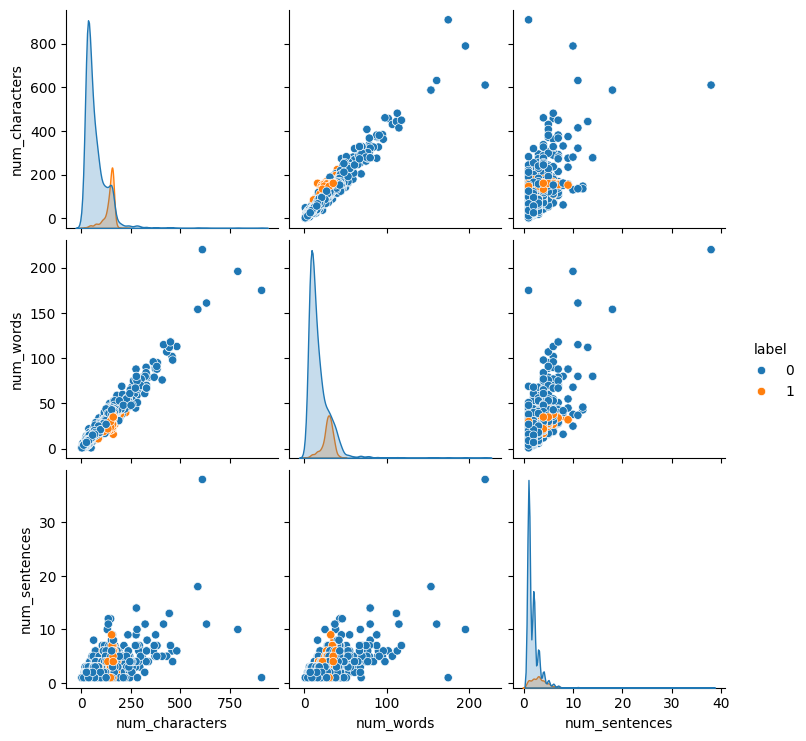

In [36]:
sns.pairplot(data_eda,hue='label')

In [37]:
#sns.heatmap(data_eda.corr(),annot=True,cmap='Greens')

### EDA  Inference - it looks there is correlation between characters, words and sentences also words count for spam are more compared to ham text 

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4.Pre processing </h2>
</div>

In [38]:
nltk.download('stopwords')
#The line nltk.download('stopwords') in NLTK downloads a collection of stopwords for various languages.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karlj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()    

def transform_text(text):
    text=text.lower()
    y=[]
    #tokenization
    text=nltk.word_tokenize(text)
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    #removing stopwords and punctuations
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    
    #stemming applied on text
    for i in text:
        y.append(ps.stem(i))
    return y

data_eda['transformed_text']=data_eda['text'].apply(transform_text)


In [40]:
%pip install wordcloud 

Note: you may need to restart the kernel to use updated packages.


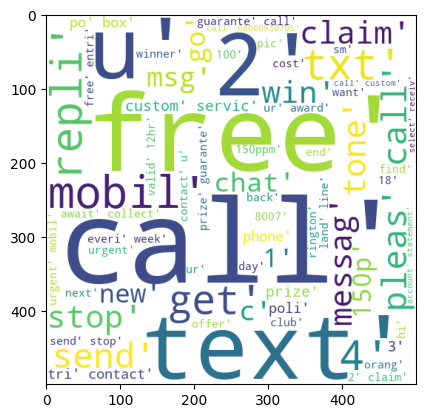

In [41]:
#lets check the most occuring words using wordcloud library
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc=wc.generate(data_eda[data_eda['label']==1]['transformed_text'].astype('str').str.cat(sep=" "))
plt.imshow(spam_wc)




In [42]:
#counting the no of words repeating
spam_corpus=[]
for msg in data_eda[data_eda['label']==1]['transformed_text'].tolist():
    for word in msg:
        spam_corpus.append(word)
len(spam_corpus)
        

11490

Text(0.5, 1.0, 'top 30 repeating words in spam text')

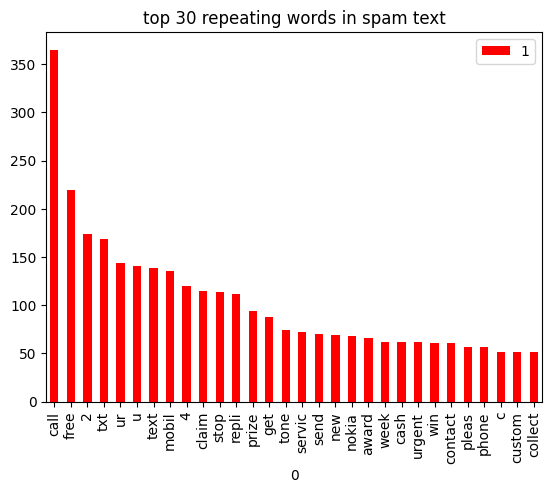

In [43]:
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(30)).plot(kind='bar',x=0,color='red')
plt.title("top 30 repeating words in spam text")

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
k=tf.fit_transform(data_eda['transformed_text'].astype('str')).toarray()
k.shape

AttributeError: module 'tensorflow' has no attribute 'fit_transform'

In [ ]:
k=pd.DataFrame(k,columns=tf.get_feature_names_out())
k

,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,02073162414,02085076972,...,zouk,zyada,åè10,åð,åòharri,åòit,åômorrow,åôrent,ìä,ìï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#vector embedding -convert text to numerical as per their occurence frequency
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv=CountVectorizer()
tf=TfidfVectorizer()
X=tf.fit_transform(data_eda['transformed_text'].astype('str')).toarray()
X=pd.DataFrame(X,columns=tf.get_feature_names())
X.shape


(5572, 6708)

In [ ]:
from sklearn.model_selection import train_test_split
y=data_eda['label']
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,random_state=33)

In [ ]:
# #copy the preprocessing.py code to s3 bucket
# codeprefix=prefix + '/code'
# codeupload=sess.upload_data('data_preprocessing.py',bucket=rawbucket,key_prefix=codeprefix)


### specify where the training and test data must be stored

In [ ]:
# #setting the s3 buckets information to output stored
# train_data_location=rawbucket +'/'+ traindataprefix
# test_data_location=rawbucket+'/'+ testdataprefix
# print(f"Training data location -{train_data_location}")
# print(f"Test data location - {test_data_location}")

### __Run The Pre-Processing Job__ 

In [ ]:
# from sagemaker.processing import ProcessingInput,ProcessingOutput
# sklearnpreprocessor.run(code=codeupload,
#                         inputs=[ProcessingInput(source=raw_data_location,destination='/opt/ml/processing/input')],
#                         outputs=[ProcessingOutput(output_name='train_data',source='/opt/ml/processing/train',destination='s3://'+ train_data_location),
#                                  ProcessingOutput(output_name='test_data',source='/opt/ml/processing/test',destination='s3://'+ test_data_location),
#                                  ProcessingOutput(output_name='train_data_headers',source='/opt/ml/processing/train_headers',destination='s3://' + rawbucket + '/' + prefix +'/train_headers')],
#                         arguments=['--train-test-split-ratio','0.2']
#                        )
# preprocessing_job_description=sklearnpreprocessor.jobs[-1].describe()
# output_config = preprocessing_job_description['ProcessingOutputConfig']

# for output in output_config['Outputs']:
#     if output['OutputName'] == 'train_data':
#         preprocessed_training_data = output['S3Output']['S3Uri']
#     if output['OutputName'] == 'test_data':
#         preprocessed_test_data = output['S3Output']['S3Uri']
                                        

### Lets do scaling to make all features on same scale


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# X_train=scaler.fit_transform(X_train)


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5.Model Building </h2>
</div>

### model building using all the common classifier models 

In [ ]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.svm import SVC
import time
import datetime
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report,f1_score
from sklearn.metrics import make_scorer
f1_scorer=make_scorer(f1_score)

In [ ]:
# creating two dataframe for storing hyperparameters and model's output
df_models_output=pd.DataFrame(columns=['model','accuracy','precision','recall','roc','f1_score'])
df_models_output
df_hyperparameter=pd.DataFrame(columns=['modelname','hyperparameter'])

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,plot_roc_curve,RocCurveDisplay
def compute_evaluation_metric(algo,X_test,y_actual,y_pred,y_pred_prob):
    cm=confusion_matrix(y_actual,y_pred,labels=y.value_counts().index)
    print(f"confusion matrix -\n {cm}\n")
    accuracy=accuracy_score(y_actual,y_pred)
    print(f"accuracy score : {accuracy}")
    #print(f"macro averaged OvR AUC score : {roc_auc_score(y_actual,y_pred_prob,multi_class='ovr',average='macro')}")
    
    
    TP=(np.diag(cm))
    
    FP=(cm.sum(axis=0)-np.diag(cm))
    #print(FP)
    FN=(cm.sum(axis=1)-np.diag(cm))
    #print(FN)
    #print(f"cm sum -{cm.sum()}")
    TN=cm.sum()-(FP+FN+TP)
    #print(TN)
    
    TPR=np.round(np.mean(TP/(TP+FN)),4)
    TNR=np.round(np.mean(TN/(TN+FP)),4)
    FPR=np.round(np.mean(FP/(FP+TN)),4)
    precision=(TP/(TP+FP))
    f1score=f1_score(y_test,y_pred)
    print(f"Precision for positive class is {precision}")
    print(f"TPR/Recall is {TPR}")
    print(f"TNR/Specifity is {TNR}")
    #print(f"FNR is {FNR}")
    print(f"FPR is {FPR}" )
    print(f"F1 score is - {f1score}")
    print(f"\n classification report - :\n {classification_report(y_actual,y_pred)}")
    ROC=roc_auc_score(y_actual,y_pred)
    print(f"ROC -{ROC} ") # ROC curve method for binary classification problems
    RocCurveDisplay.from_predictions(y_actual,y_pred)
    plt.show()
    return algo,accuracy,precision,TPR,ROC,f1score

#### Model 1- Naive beyes model 

In [ ]:
%%time
#lets use hyperparamater tuning for NB model

import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# mnb=MultinomialNB()
# parmas={"alpha":[.001,.01,.1,1,2]}
# cv_method=RepeatedStratifiedKFold(n_splits=10,n_repeats=10,random_state=33)
# gs_nb=GridSearchCV(estimator=mnb,
#                   cv=cv_method,
#                   param_grid=parmas,
#                   verbose=1,
#                   scoring=f1_scorer)
# gs_nb.fit(X_train,y_train)
# print(gs_nb.best_estimator_)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
#hyperparameters for NB are MultinomialNB(alpha=0.1)
df_hyperparameter=df_hyperparameter.append({'modelname':'MultiNB','hyperparameter':'MultinomialNB(alpha=0.1,1)'},ignore_index=True)
df_hyperparameter

,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"


#### Model 2 - Support vector machine 

In [ ]:
%%time
#hyperparameter tunning for SVM
# from sklearn.svm import SVC
# svc= SVC()
# params={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001],'kernel':['rbf','sigmoid']}
# gs_svc=GridSearchCV(estimator=svc,
#                    cv=cv_method,
#                    param_grid=params,
#                    verbose=1,
#                  )
# gs_svc.fit(X_train,y_train)
# print(gs_svc.best_estimator_)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
#SVC hyeprparameters= SVC(C=10, gamma=0.1)
df_hyperparameter=df_hyperparameter.append({'modelname':'SVC','hyperparameter':'SVC(C=10, gamma=0.1)'},ignore_index=True)
df_hyperparameter

,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"
1,SVC,"SVC(C=10, gamma=0.1)"


### Model 3 - KNN model 

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
#hyperparameter modelling for KNN
# KNN=KNeighborsClassifier()
# params={'n_neighbors':[2,4,8,16],
#     'weights':['uniform','distance']
# }
# gs_knn=GridSearchCV(estimator=KNN,
#                     param_grid=params,
#                    cv=cv_method,
#                    verbose=1)
# gs_knn.fit(X_train,y_train)
# print(gs_knn.best_params_)


CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
#KNN hyperparameters- {'n_neighbors': 2, 'weights': 'distance'}
df_hyperparameter=df_hyperparameter.append({'modelname':'KNN','hyperparameter':'n_neighbors: 2, weights: distance'},ignore_index=True)
df_hyperparameter

,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"
1,SVC,"SVC(C=10, gamma=0.1)"
2,KNN,"n_neighbors: 2, weights: distance"


### Model 4- Random forest Model 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#rf=RandomForestClassifier()
# params={'criterion' : ['gini', 'entropy'],
#     'max_features' : ['sqrt', 'log2']}
# gs_rf=GridSearchCV(estimator=rf,
#                   cv=cv_method,
#                   param_grid=params,
#                   verbose=1,
#                   n_jobs=-1,
#                   scoring='accuracy')
# gs_rf.fit(X_train,y_train)
# print(gs_rf.best_estimator_)

In [ ]:
#RF best hyperparameter -{'criterion': 'gini', 'max_features': 'sqrt'}
df_hyperparameter=df_hyperparameter.append({'modelname':'RF','hyperparameter':'criterion: gini, max_features: sqrt'},ignore_index=True)
df_hyperparameter


,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"
1,SVC,"SVC(C=10, gamma=0.1)"
2,KNN,"n_neighbors: 2, weights: distance"
3,RF,"criterion: gini, max_features: sqrt"


### Model 5 - XGBooster 

In [ ]:
from xgboost import XGBClassifier
XGB=XGBClassifier(learning_rate=0.1,n_estimators=150)
# XGB.fit(X_train,y_train)
# params={'n_estimators':[100,125,150],
#        'learning_rate':[0.05,0.1],
#         }

# gs_xgb=GridSearchCV(param_grid=params,
#                    estimator=XGB,
#                    )
# gs_xgb.fit(X_train,y_train)



In [ ]:
#XGBoost best hyperparameters {'learning_rate': 0.1, 'n_estimators': 150}
df_hyperparameter=df_hyperparameter.append({'modelname':'XGB','hyperparameter':'learning_rate: 0.1, n_estimators: 150'},ignore_index=True)
df_hyperparameter


,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"
1,SVC,"SVC(C=10, gamma=0.1)"
2,KNN,"n_neighbors: 2, weights: distance"
3,RF,"criterion: gini, max_features: sqrt"
4,XGB,"learning_rate: 0.1, n_estimators: 150"


### Model  6- AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ABoost=AdaBoostClassifier(n_estimators=200,learning_rate=0.1)

# params={'n_estimators':[200,300],
#         'learning_rate':[0.1]
#        }
# gs_Aboost=GridSearchCV(estimator=ABoost,
#                       cv=cv_method,
#                       param_grid=params,
#                       scoring='accuracy')

# gs_Aboost.fit(X_train,y_train)


In [ ]:
#adaboost hyperparammeter  best - AdaBoostClassifier(learning_rate=0.1, n_estimators=200)


In [ ]:
df_hyperparameter=df_hyperparameter.append({'modelname':'ABoost','hyperparameter':'learning_rate: 0.1, n_estimators: 200'},ignore_index=True)
df_hyperparameter


,modelname,hyperparameter
0,MultiNB,"MultinomialNB(alpha=0.1,1)"
1,SVC,"SVC(C=10, gamma=0.1)"
2,KNN,"n_neighbors: 2, weights: distance"
3,RF,"criterion: gini, max_features: sqrt"
4,XGB,"learning_rate: 0.1, n_estimators: 150"
5,ABoost,"learning_rate: 0.1, n_estimators: 200"


### Hyperparameter tuning competed , lets fit all  the 6 models 

In [ ]:
#creating instance for all the best available models 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
mnb=MultinomialNB(alpha=0.1) #multinominal naives bayes
svc=SVC(C=10,gamma=0.1,kernel='sigmoid',probability=True) #support vector machine
knn=KNeighborsClassifier() #k-nearest neighnour
rf=RandomForestClassifier(criterion='gini',max_features='sqrt',random_state=33) #random forest
xgb=XGBClassifier(learning_rate=0.1,n_estimators=150,random_state=33) #Extreme gradient boosting
adbst=AdaBoostClassifier(learning_rate=0.1,n_estimators=200,random_state=33) #adaptive boosting

estimators=[('nb',mnb),('svc',svc),('xg',xgb)]
Vclf=VotingClassifier(estimators=estimators,voting='soft') #voting classifier

final_estimator=rf
sclf=StackingClassifier(estimators=estimators,final_estimator=final_estimator) #stcking classifier



MultinomialNB
confusion matrix -
 [[1436   13]
 [  21  202]]

accuracy score : 0.9796650717703349
Precision for positive class is [0.98558682 0.93953488]
TPR/Recall is 0.9484
TNR/Specifity is 0.9484
FPR is 0.0516
F1 score is - 0.9223744292237442

 classification report - :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1449
           1       0.94      0.91      0.92       223

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672

ROC -0.9484289458943388 


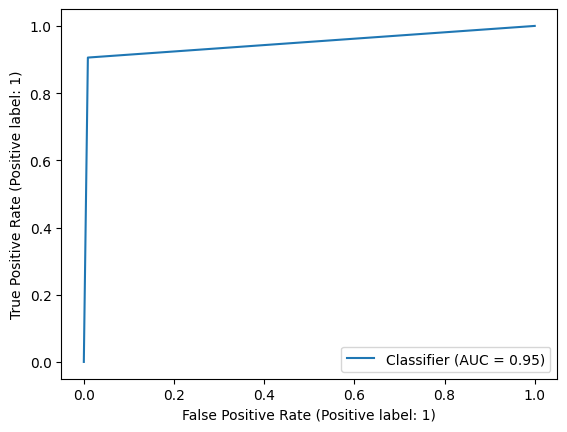

SVC
confusion matrix -
 [[1446    3]
 [  37  186]]

accuracy score : 0.9760765550239234
Precision for positive class is [0.97505057 0.98412698]
TPR/Recall is 0.916
TNR/Specifity is 0.916
FPR is 0.084
F1 score is - 0.9029126213592233

 classification report - :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.98      0.83      0.90       223

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.94      1672
weighted avg       0.98      0.98      0.98      1672

ROC -0.916005162057024 


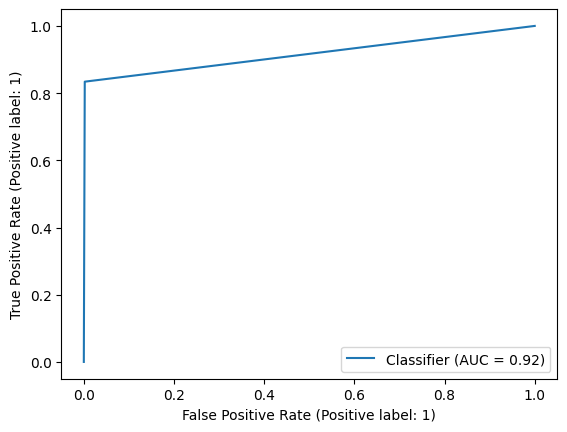

KNeighborsClassifier
confusion matrix -
 [[1449    0]
 [ 160   63]]

accuracy score : 0.9043062200956937
Precision for positive class is [0.90055935 1.        ]
TPR/Recall is 0.6413
TNR/Specifity is 0.6413
FPR is 0.3587
F1 score is - 0.4405594405594406

 classification report - :
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1449
           1       1.00      0.28      0.44       223

    accuracy                           0.90      1672
   macro avg       0.95      0.64      0.69      1672
weighted avg       0.91      0.90      0.88      1672

ROC -0.6412556053811659 


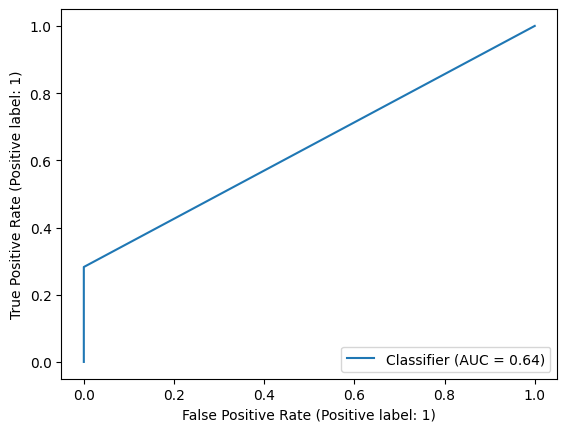

RandomForestClassifier
confusion matrix -
 [[1444    5]
 [  47  176]]

accuracy score : 0.9688995215311005
Precision for positive class is [0.96847753 0.97237569]
TPR/Recall is 0.8929
TNR/Specifity is 0.8929
FPR is 0.1071
F1 score is - 0.8712871287128713

 classification report - :
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1449
           1       0.97      0.79      0.87       223

    accuracy                           0.97      1672
   macro avg       0.97      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672

ROC -0.8928935062684331 


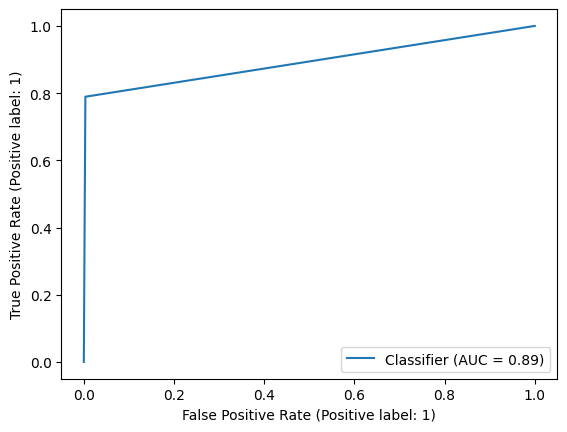

XGBClassifier
[12:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix -
 [[1434   15]
 [  39  184]]

accuracy score : 0.9677033492822966
Precision for positive class is [0.97352342 0.92462312]
TPR/Recall is 0.9074
TNR/Specifity is 0.9074
FPR is 0.0926
F1 score is - 0.8720379146919431

 classification report - :
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1449
           1       0.92      0.83      0.87       223

    accuracy                           0.97      1672
   macro avg       0.95      0.91      0.93      1672
weighted avg       0.97      0.97      0.97      1672

ROC -0.9073800703748063 


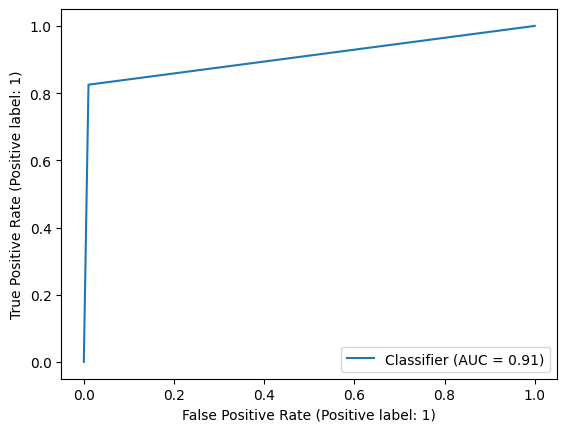

AdaBoostClassifier
confusion matrix -
 [[1447    2]
 [  61  162]]

accuracy score : 0.9623205741626795
Precision for positive class is [0.95954907 0.98780488]
TPR/Recall is 0.8625
TNR/Specifity is 0.8625
FPR is 0.1375
F1 score is - 0.8372093023255814

 classification report - :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1449
           1       0.99      0.73      0.84       223

    accuracy                           0.96      1672
   macro avg       0.97      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672

ROC -0.8625385684266557 


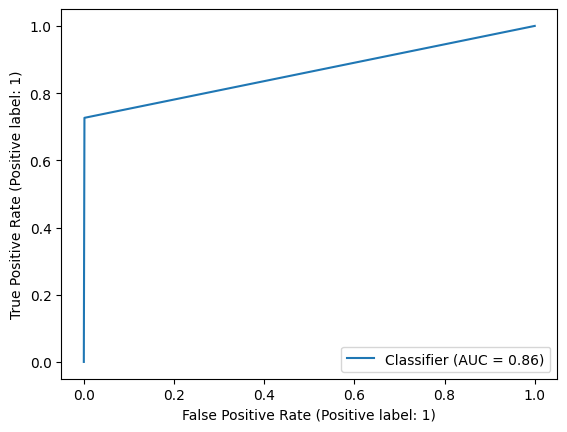

VotingClassifier
[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix -
 [[1445    4]
 [  25  198]]

accuracy score : 0.9826555023923444
Precision for positive class is [0.9829932  0.98019802]
TPR/Recall is 0.9426
TNR/Specifity is 0.9426
FPR is 0.0574
F1 score is - 0.9317647058823529

 classification report - :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.98      0.89      0.93       223

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

ROC -0.9425659260909797 


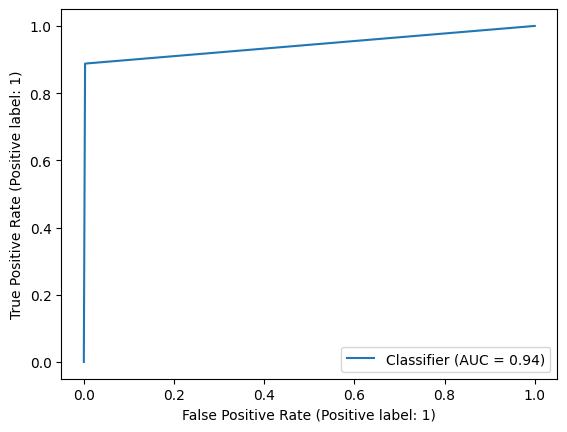

StackingClassifier
[12:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:15] WARNING: C:/Users/Administrator/workspac

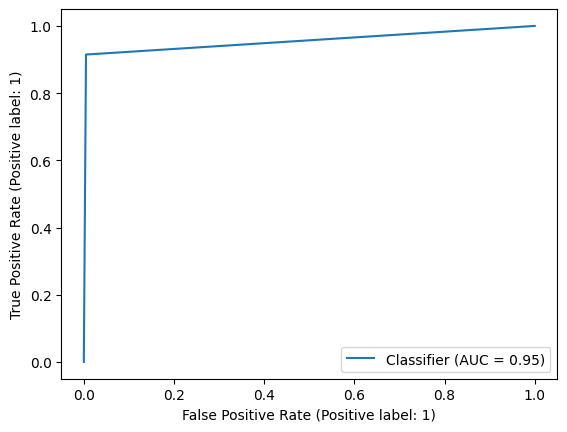

CPU times: total: 2h 24min 10s
Wall time: 37min 59s


In [ ]:
%%time
#fit the train data of each model and save the output to dataframe
for modl in (mnb,svc,knn,rf,xgb,adbst,Vclf,sclf):
    print(type(modl).__name__)
    modl.fit(X_train,y_train)
    y_pred=modl.predict(X_test)
    y_pred_prob=modl.predict_proba(X_test)
    df_models_output.loc[len(df_models_output)]=compute_evaluation_metric(type(modl).__name__,X_test,y_test,y_pred,y_pred_prob)
    

In [ ]:
#sorting the models output by accuracya nd f1_score
df_models_output.sort_values(by=['accuracy','f1_score'],ascending=False)

,model,accuracy,precision,recall,roc,f1_score
7,StackingClassifier,0.984450,"[0.9869952087611226, 0.966824644549763]",0.9550,0.954984,0.940092
6,VotingClassifier,0.982656,"[0.9829931972789115, 0.9801980198019802]",0.9426,0.942566,0.931765
0,MultinomialNB,0.979665,"[0.9855868222374743, 0.9395348837209302]",0.9484,0.948429,0.922374
1,SVC,0.976077,"[0.9750505731625084, 0.9841269841269841]",0.9160,0.916005,0.902913
3,RandomForestClassifier,0.968900,"[0.9684775318578136, 0.9723756906077348]",0.8929,0.892894,0.871287
4,XGBClassifier,0.967703,"[0.9735234215885947, 0.9246231155778895]",0.9074,0.907380,0.872038
5,AdaBoostClassifier,0.962321,"[0.9595490716180372, 0.9878048780487805]",0.8625,0.862539,0.837209
2,KNeighborsClassifier,0.904306,"[0.9005593536357986, 1.0]",0.6413,0.641256,0.440559


<div class="alert alert-info" style="background-color:Black; color:white; padding:10px; border-radius:5px;">
        <ul style="list-style-type: disc; padding-left: 20px;">
            <li><h2> Accuracy</h2>sample text</li>
            <li><h2> Precision</h2>sample text</li>
            <li><h2> Recall</h2>sample text</li>
            <li><h2> TNR</h2> sample text</li>
        </ul>
    </div>


In [ ]:
y_pred_mnb=mnb.predict(X_test)
y_pred_sclf=sclf.predict(X_test)

In [ ]:
df_test=pd.DataFrame({'y_test':y_test,'mnb':y_pred_mnb,'stacking':y_pred_sclf})
df_test[df_test['y_test']!=df_test['mnb']]

,y_test,mnb,stacking
3362,0,1,0
2662,1,0,0
4254,1,0,1
3883,1,0,0
3979,1,0,0
2967,0,1,0
1637,1,0,0
1457,1,0,0
3304,0,1,0
3434,0,1,1


#### Inference-  since out target variable(label) is imbalanced thats why we will focus on f1_score  more than accuracy and other metrics and stacking classifier has highest f1_score and accuracy and roc

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6.Model Persistence (Deployment)</h2>
</div>

### save the model using pythons built in persistence model, namely pickle 

In [ ]:
import pickle  #used to create pickle files
import joblib  #used to save models


####  we will load the stacking  model and tfid 
#### we will first save the model locally and then will deploy it to AWS EC2

In [ ]:
print("creating pickle file")
pickle.dump(sclf,open('spam_detector.pkl','wb'))
pickle.dump(tf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('mnb_spam_detector.pkl','wb'))


creating pickle file
